# Introdução

**Nesse primeiro notebook, nosso propósito é fazer uma análise inicial dos dados do dataset de bicicletas compartilhadas de nova iorque e entender suas peculiaridades nos dados.**

# Importações

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import pyarrow.parquet as pq

In [3]:
from haversine import haversine

In [4]:
px.set_mapbox_access_token("pk.eyJ1Ijoicm1jbnJpYmVpcm8iLCJhIjoiY2s4MHh5b3ZiMGtsbTNkcGFuazR1dWc4diJ9._aDTNPlmw3Nt6QSMm3YgmQ")

**Importante**: Devido a restrição de espaço no Github, baixe os dados do Drive e coloque localmente na pasta 'Dados'.
https://drive.google.com/drive/folders/144_0BrEXS3Z1VslYxr1rP2Wr6bSm4tDf?usp=sharing

In [5]:
url='https://drive.google.com/file/d/1x74szuO_xoNyQqeBrn6df6HmzCMv-QQ5/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_trips_filtrado = pd.read_parquet(url)

In [6]:
df_trips_filtrado

Trip Duration              Start Time               Stop Time  \
16303534            882 2018-11-25 18:21:38.774 2018-11-25 18:36:21.472   
10311866            669 2018-08-13 18:25:50.544 2018-08-13 18:36:59.968   
17229606            521 2018-12-18 20:12:15.062 2018-12-18 20:20:57.017   
4463430             270 2018-05-18 14:23:52.105 2018-05-18 14:28:22.491   
10376436            441 2018-08-14 19:00:15.867 2018-08-14 19:07:37.052   
...                 ...                     ...                     ...   
499995             1658 2019-06-12 22:09:26.375 2019-06-12 22:37:05.244   
499996              294 2019-10-04 15:13:45.883 2019-10-04 15:18:40.101   
499997             1386 2019-06-09 13:46:00.828 2019-06-09 14:09:07.822   
499998             1648 2019-09-26 17:48:29.830 2019-09-26 18:15:57.963   
499999              506 2019-05-29 16:56:05.696 2019-05-29 17:04:32.584   

          Start Station ID          Start Station Name  \
16303534               423             W 54 St & 9 Ave   
10311866              3467  W Broadway & Spring Street   
17229606               411           E 6 St & Avenue D   
4463430                437     Macon St & Nostrand Ave   
10376436               519       Pershing Square North   
...                    ...                         ...   
499995                3310               14 St & 7 Ave   
499996                3062      Myrtle Ave & Marcy Ave   
499997                 311      Norfolk St & Broome St   
499998                 266           Avenue D & E 8 St   
499999                3345       Madison Ave & E 99 St   

          Start Station Latitude  Start Station Longitude  End Station ID  \
16303534               40.765849               -73.986905             476   
10311866               40.724947               -74.001659             327   
17229606               40.722281               -73.976687             504   
4463430                40.680983               -73.950048            3047   
10376436               40.751873               -73.977706             498   
...                          ...                      ...             ...   
499995                 40.663779               -73.983968             414   
499996                 40.695398               -73.949549             373   
499997                 40.717227               -73.988021             143   
499998                 40.723684               -73.975748            3680   
499999                 40.789485               -73.952429            3507   

                      End Station Name  End Station Latitude  \
16303534               E 31 St & 3 Ave             40.743943   
10311866      Vesey Pl & River Terrace             40.715338   
17229606               1 Ave & E 16 St             40.732219   
4463430       Halsey St & Tompkins Ave             40.682369   
10376436            Broadway & W 32 St             40.748549   
...                                ...                   ...   
499995         Pearl St & Anchorage Pl             40.702819   
499996    Willoughby Ave & Walworth St             40.693317   
499997       Clinton St & Joralemon St             40.692395   
499998                 E 43 St & 5 Ave             40.754121   
499999             Park Ave & E 124 St             40.804555   

          End Station Longitude  Bike ID   User Type  Birth Year  Gender  \
16303534             -73.979661    20049    Customer        1969       0   
10311866             -74.016584    33847  Subscriber        1987       1   
17229606             -73.981656    30284  Subscriber        1971       1   
4463430              -73.944118    31542  Subscriber        1964       1   
10376436             -73.988084    18363  Subscriber        1979       1   
...                         ...      ...         ...         ...     ...   
499995               -73.987658    34104  Subscriber        1981       2   
499996               -73.953820    14887  Subscriber        1986       1   
499997               -73.993379   

# Análise de Sazonalidade

## Construção da Série Temporal

In [12]:
df_time_series = df_trips_filtrado.copy()

In [13]:
df = df_time_series.copy()
df["Date-Hour"] = df["Start Time"].dt.floor("H").copy()
usage_series = df.groupby("Date-Hour").size().asfreq("h")

In [14]:
usage_series.head()

Date-Hour
2018-01-01 00:00:00    4.0
2018-01-01 01:00:00    5.0
2018-01-01 02:00:00    4.0
2018-01-01 03:00:00    1.0
2018-01-01 04:00:00    NaN
Freq: H, dtype: float64

In [15]:
# Precisamos que o dataframe tenha a propriedade de frequência por hora
usage_series = usage_series.asfreq('h')

In [16]:
# Precisamos preencher os buracos vazios com uma interpolação
usage_series = usage_series.interpolate()

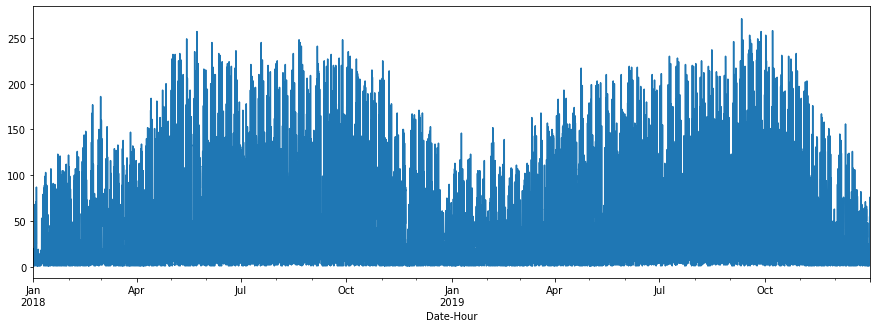

In [17]:
usage_series.plot(figsize=(15,5))

## Análise da Decomposição de Sazonalidade

No estudo de séries temporais a sazonalidade é uma questão importante pois define o padrão de comportamento da série. Uma técnica de estudo de sazonalidade é a partir da decomposição em três partes:

* **Tendência:** Define a análise macro do comportamento da curva, que é a tendência geral para cada ponto da série.
* **Sazonalidade:** Define os padrões mais localizados/micros da curva.
* **Resíduo:** Todo o restante que não pode ser predito. Essa é uma medida importante porque em teoria deve ser aleatória, não demonstrando padrões nos resíduos. Se houverem razões podemos concluir que nosso modelo de decomposição não entende completamente os dados e está perdendo padrões.

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

https://otexts.com/fpp3/

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
result = seasonal_decompose(usage_series, model='additive')

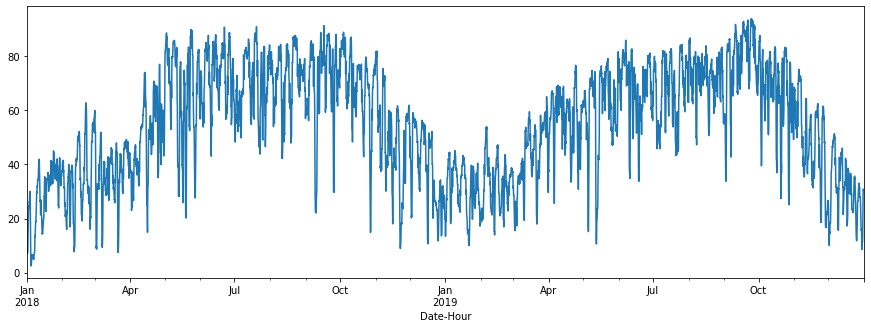

In [20]:
result.trend.plot(figsize=(15,5))

Podemos ver que a tendência capturou uma alta de acordo com os meses mais centrais do ano. Além disso, podemos ver que ela capturou curvas semanais, indicando o comportamento de sazonalidades semanais.

**Importante**: A tendência deve ser uma curva muito linear, pois não deve levar em consideração as volatilidades micro. O significado dessa sazonalidade embutida na tendência é que nossa componente de sazonalidade não deu conta de descobrir todos os padrões. Isso porque podemos encontrar três sazonalidades nos nossos dados: horária, diária e semanal. Podemos até encontrar uma anual se quisermos.

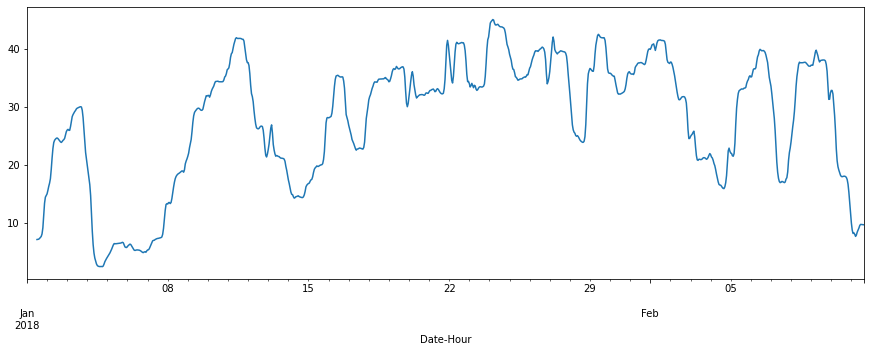

In [21]:
result.trend[:1000].plot(figsize=(15,5))

Na análise da sazonalidade podemos ver que capturou a sazonalidade diária. Em uma análise mais profunda podemos ainda ver que essa é a sazonalidade dos dias de semana, visto que o comportamento dos fins de semana é diferente. Isso mostra como as múltiplas sazonalidades não foram captadas.

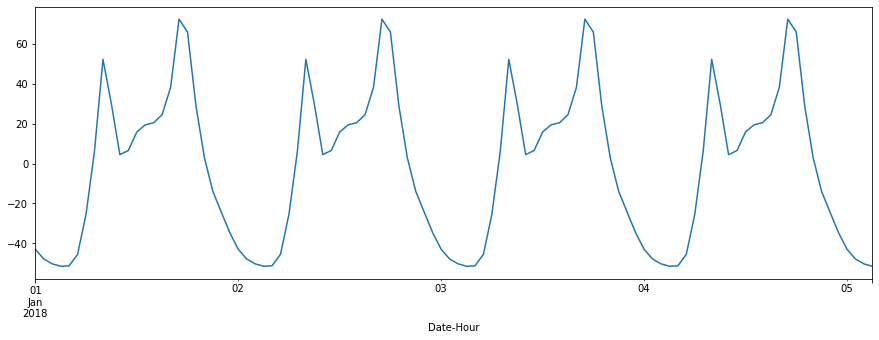

In [22]:
result.seasonal[:100].plot(figsize=(15,5))

Com os resíduos também podemos ver as sazonalidades que escaparam do modelo.

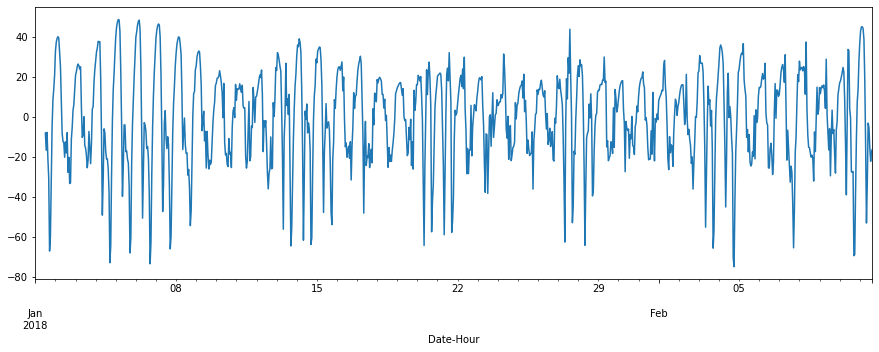

In [23]:
result.resid[:1000].plot(figsize=(15,5))

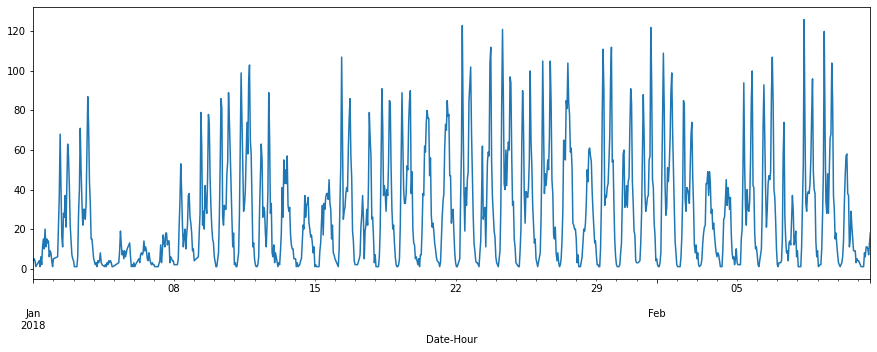

In [24]:
result.observed[:1000].plot(figsize=(15,5))

# Predição de Série Temporal

In [25]:
split_index = int(len(usage_series) * 0.7)

train_series = usage_series.iloc[:split_index]
test_series = usage_series.iloc[split_index:]

## AutoArima

In [26]:
# import pmdarima

In [27]:
# train_series.plot()

In [28]:
# arima_model = pmdarima.arima.auto_arima(
#     train_series, 
#     seasonal=True,
#     m=24, # total do periodo em horas
#     trace=True # mostra o status de cada treinamento
# )

In [29]:
# arima_model.predict(len(test_series))

## FourierCalendar + Regressão Linear

https://www.kaggle.com/code/ryanholbrook/seasonality

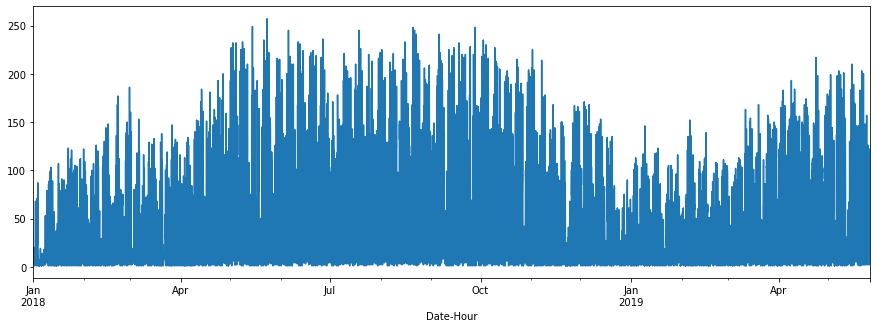

In [30]:
train_series.plot(figsize=(15,5))

In [31]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="Y", order=365)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train_series.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [32]:
# px.line(X.iloc[:100])

In [33]:
X["isweekend"] = ((X.index.dayofweek == 5) | (X.index.dayofweek == 6)).astype(int)

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
linear_reg_model = LinearRegression().fit(X, train_series)

In [36]:
X_test = dp.out_of_sample(len(test_series))
X_test["isweekend"] = ((X_test.index.dayofweek == 5) | (X_test.index.dayofweek == 6)).astype(int)

In [37]:
X_test.head()

const    trend  s(2,24)  s(3,24)  s(4,24)  s(5,24)  \
2019-05-27 00:00:00    1.0  12265.0      0.0      0.0      0.0      0.0   
2019-05-27 01:00:00    1.0  12266.0      1.0      0.0      0.0      0.0   
2019-05-27 02:00:00    1.0  12267.0      0.0      1.0      0.0      0.0   
2019-05-27 03:00:00    1.0  12268.0      0.0      0.0      1.0      0.0   
2019-05-27 04:00:00    1.0  12269.0      0.0      0.0      0.0      1.0   

                     s(6,24)  s(7,24)  s(9,24)  s(10,24)  ...  \
2019-05-27 00:00:00      0.0      0.0      0.0       0.0  ...   
2019-05-27 01:00:00      0.0      0.0      0.0       0.0  ...   
2019-05-27 02:00:00      0.0      0.0      0.0       0.0  ...   
2019-05-27 03:00:00      0.0      0.0      0.0       0.0  ...   
2019-05-27 04:00:00      0.0      0.0      0.0       0.0  ...   

                     cos(361,freq=A-DEC)  sin(362,freq=A-DEC)  \
2019-05-27 00:00:00            -0.809017            -0.951057   
2019-05-27 01:00:00            -0.932548            -0.839841   
2019-05-27 02:00:00            -0.993906            -0.672323   
2019-05-27 03:00:00            -0.988998            -0.459733   
2019-05-27 04:00:00            -0.918153            -0.216323   

                     cos(362,freq=A-DEC)  sin(363,freq=A-DEC)  \
2019-05-27 00:00:00             0.309017             0.951057   
2019-05-27 01:00:00             0.542833             0.998553   
2019-05-27 02:00:00             0.740258             0.978740   
2019-05-27 03:00:00             0.888057             0.892952   
2019-05-27 04:00:00             0.976322             0.746972   

                     cos(363,freq=A-DEC)  sin(364,freq=A-DEC)  \
2019-05-27 00:00:00             0.309017            -0.587785   
2019-05-27 01:00:00             0.053768            -0.776694   
2019-05-27 02:00:00            -0.205104            -0.912961   
2019-05-27 03:00:00            -0.450152            -0.987349   
2019-05-27 04:00:00            -0.664855            -0.994818   

                     cos(364,freq=A-DEC)  sin(365,freq=A-DEC)  \
2019-05-27 00:00:00            -0.809017        -7.839225e-14   
2019-05-27 01:00:00            -0.629878         2.588190e-01   
2019-05-27 02:00:00            -0.408047         5.000000e-01   
2019-05-27 03:00:00            -0.158559         7.071068e-01   
2019-05-27 04:00:00             0.101675         8.660254e-01   

                     cos(365,freq=A-DEC)  isweekend  
2019-05-27 00:00:00             1.000000          0  
2019-05-27 01:00:00             0.965926          0  
2019-05-27 02:00:00             0.866025          0  
2019-05-27 03:00:00             0.707107          0  
2019-05-27 04:00:00             0.500000          0  

[5 rows x 754 columns]

In [39]:
series_prediction = linear_reg_model.predict(X_test)

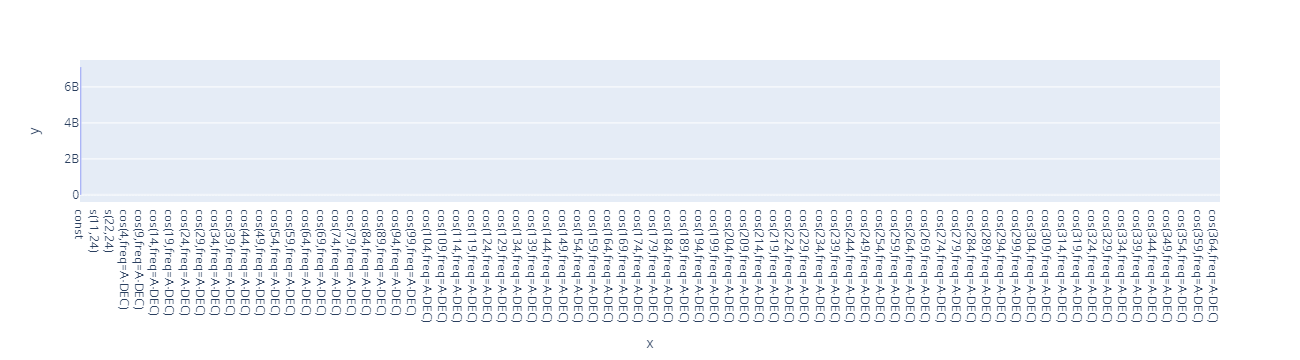

In [52]:
px.bar(x=X_test.columns, y=linear_reg_model.coef_)

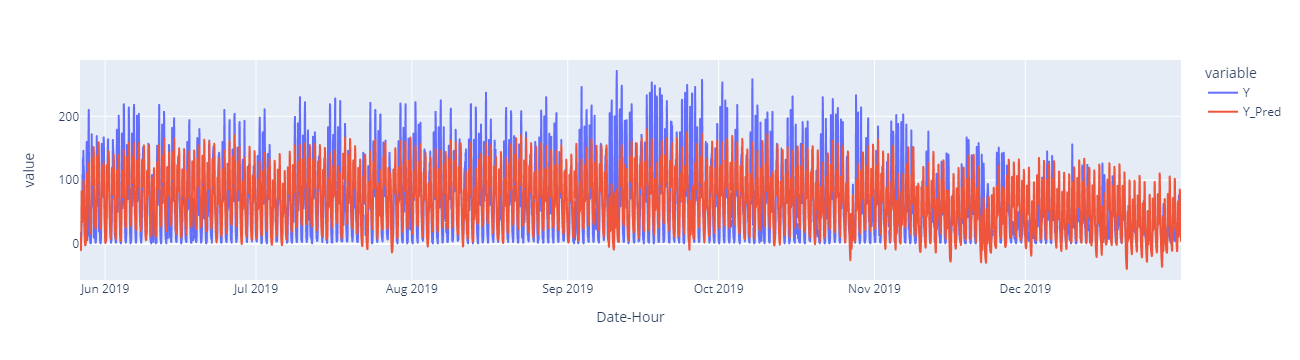

In [41]:
comparison = pd.DataFrame({
    "Y": test_series,
    "Y_Pred": series_prediction
})

px.line(comparison)

In [42]:
from sklearn import metrics

In [43]:
import math

In [44]:
mse = metrics.mean_squared_error(test_series, series_prediction)

In [45]:
rmse = math.sqrt(mse)

In [46]:
mape = metrics.mean_absolute_percentage_error(test_series, series_prediction)

In [47]:
mae = metrics.median_absolute_error(test_series, series_prediction)

In [48]:
print(mse, rmse, mape, mae)

1062.9428660025271 32.602804572651834 1.5145626741428138 19.115405559539795
